# Krista, working on linking CO and KO
27 August 2015; 30 September 2015
12 October 2015: common reactions AND find the optimal number of K means groups
12 November 2015: change to using biopython modules to merge KO and CO information for Kmeans groups
19 November 2015: add in centered log ratio code for KO (compositional) data

In [1]:
#let norm2max run over Thanksgiving

Have now used biopython code at end to merge cpds and genes in pathways. THis version also considers the
KO data as composisional data and uses a centered log-ratio to 'correct' the KO data

The KEGG CO numbers from the RI data are not unique. In MATLAB, I have created a new value 'RInumber' which is an arbitrary number for each 'mzRT' feature. The data exported out of MATLAB include that number, the corresponding KEGG CO number, and whether the feature was observed in positive or negative ion mode. These data will be uesd to create a lookup table which allow use of the CO numbers or RInumbers as needed.

In [2]:
import pandas as pd
import urllib2
from bs4 import BeautifulSoup
import re
from sklearn.cluster import KMeans
import palettable as pal
from itertools import chain
import os
import numpy as np
from IPython.core.debugger import Tracer #used this to step into the function and debug it, also need line with Tracer()() 
import matplotlib.pyplot as plt

%matplotlib inline

Also, will need to export the following from MATLAB
(1) RInumber, (2) CO number, (3) ion mode information

In [3]:
mtabFile = 'RImetabolites_isomers.2015.08.27.csv' #first column is RInumber

In [4]:
CO_fromMATLAB=pd.read_csv(mtabFile, index_col='RInumber')
# CO_fromMATLAB=CO_RawData[CO_RawData.sum(axis=1)!=0]
#read in the data from MATLAB and take a quick look
CO_fromMATLAB.head(n=5)

,cNumber,ChargedMass,RT,ionMode,S1,S2,S3,S4,S5
RInumber,,,,,,,,,
RI1,C06593,114.091340,420.6627,positive,0.005583,0.005715,0.006027,0.002645,0.003441
RI2,C01585,117.091006,343.2985,positive,0.000305,0.000486,0.000613,0.000389,0.000436
RI3,C02948,117.091006,343.2985,positive,0.000305,0.000486,0.000613,0.000389,0.000436
RI4,C03739,117.091006,343.2985,positive,0.000305,0.000486,0.000613,0.000389,0.000436
RI5,C12293,117.091006,343.2985,positive,0.000305,0.000486,0.000613,0.000389,0.000436


make the list of unique cNumbers here, do the KEGG thing and filter the list before I start splitting up the dataframes into data and metadata...

In [5]:
#make a list of the unique CO numbers for the CreateHash_COtoKO.py. Export the list as CSV
td = CO_fromMATLAB.groupby('cNumber').count()
COnumbers = td.drop(list(td.columns.values),axis=1)
del td
COnumbers.to_csv('exportCOnumbers.csv',header=True)

###Write a couple of functions to swap between CO and RInumbers

In [6]:
def findRInumber(dataIn,KEGGin):
    #find possible RI numbers for a given KEGG number. 
    dataOut = []
    for i,KEGG in enumerate(dataIn['KEGG']):
        if KEGG == KEGGin:
            t = dataIn.index[i]
            dataOut.append(t)
    return dataOut

##For example: this will give back one row, C18028 will be multiple
#m = findRInumber(forRelatedness,'C00078') 

In [7]:
def convertRItoCO(dataIn,RIin):
    #do the reverse, given an RInumber find the cNumber
    dataOut = dataIn.loc[RIin].loc['cNumber']
    return dataOut

##This will always be a single value
#m = convertRItoCO(forRelatedness,'RI2')

In [8]:
#slight change, no need to send in a comparison file if it always the same thing
def convertRItoCO2(RIin):
    #do the reverse, given an RInumber find the cNumber
    dataOut = CO_fromMATLAB.loc[RIin].loc['cNumber']
    return dataOut

##This will always be a single value, also uses CO_fromMATLAB as input 

In [9]:
#wonder whether these should be defined at the top?
import os.path
import cPickle as cpk

This grabs the CO/KO links from the KEGG website. The actual code is in the CreateHash_COtoKO.py that Harriet wrote. Note that since the exportCOnumbers.csv file is a unique list of C number we essentially already have a lookup table for all the metabolites of interest.

In [10]:
if os.path.isfile('exportCOnumbers.csv' + '.pickle'):
    #just read in the file
    WorkingFile = cpk.load(open('exportCOnumbers.csv.pickle','r'))
else:
    #need to make the file
    filename = "CreateHash_COtoKO.py"
    %run $filename exportCOnumbers.csv 
    #then read in the file
    WorkingFile = cpk.load(open('exportCOnumbers.csv.pickle','r'))


In [11]:
def SplitCODict(WorkingFile):
    CO_withoutKO={}
    CO_withKO={}
    for CO in WorkingFile.keys():

        if WorkingFile[CO]['Related KO']==[]:
            CO_withoutKO[CO]=WorkingFile[CO]
        else:
            CO_withKO[CO]=WorkingFile[CO]
    return CO_withoutKO, CO_withKO

CO_withoutKO, CO_withKO=SplitCODict(WorkingFile)
print 'There are', len(CO_withKO), 'COs with an associated KO.', len(CO_withoutKO), 'are not associated with a KO.'



There are 404 COs with an associated KO. 1438 are not associated with a KO.


In [12]:
AllKO=[]
AllCO=[]
for key in CO_withKO:
    AllKO.append(CO_withKO[key]['Related KO'])
    AllCO.append(CO_withKO[key]['Related CO'])
AllKO=list(set([item for sublist in AllKO for item in sublist]))
AllCO=list(set([item for sublist in AllCO for item in sublist]))

# KO_limited_Norm2Mean=KO_Norm2Mean.loc[AllKO].dropna()
# CO_limited_Norm2Mean=CO_Norm2Mean.loc[AllCO].dropna()

In [13]:
#go through CO_RawData_all one row at a time (inefficient for sure, but I understand 
#what is happening), then make a new column in CO_RawData_all that is True/False
CO_fromMATLAB['inList'] = ""

for idx in range(0,len(CO_fromMATLAB)):
# for idx in range(0):
    fc = CO_fromMATLAB.ix[idx,'cNumber']
    if fc in AllCO:
        CO_fromMATLAB.ix[idx,'inList'] = True
    else:
        CO_fromMATLAB.ix[idx,'inList'] = False  

In [14]:
#can't quite figure out how to do this in one step.
m = CO_fromMATLAB[CO_fromMATLAB['inList']==True]
CO_metadata_pruned = m.loc[:,['cNumber','ChargedMass','RT','ionMode']]

#this list of days is useful, so define it up front. Actually want something that can't change 
#but had trouble getting a tuple to work as an index.
dayList = ['S1','S2','S3','S4','S5'] #this makes a list (mutable, can be changed)
#days = ('S1','S2','S3','S4','S5') #this makes a tuple (immutable)
CO_RawData_pruned = m.loc[:,dayList]
del m

This is the new version, with the extended metadata. Parse the file into data and metadata.

In [15]:
#read in the KO data
KO_RawData=pd.read_csv('AllPhytoKegg_KO_counts.tab', index_col='gID', delimiter='\t')
KO_RawData=KO_RawData[KO_RawData.sum(axis=1)!=0]

In [16]:
##took out the compositional data analysis pieces...that was a mess

##

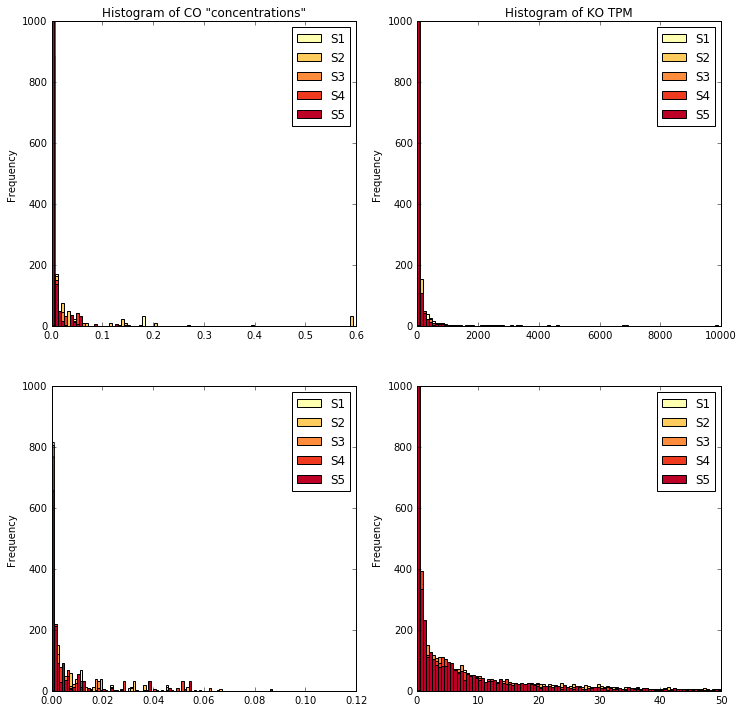

In [17]:
cmap=pal.colorbrewer.sequential.YlOrRd_5.get_mpl_colormap()
fig, axs=plt.subplots(2,2) 
fig.set_size_inches(12,12)
for ax in axs:
    for a in ax: 
        a.set_ylim([0,1000])
CO_RawData_pruned.plot(kind='hist', bins=100,colormap=cmap, ax=axs[0][0])
axs[0][0].set_title('Histogram of CO "concentrations"', size='large')
KO_RawData.plot(kind='hist', bins=100,colormap=cmap,ax=axs[0][1])
axs[0][1].set_title('Histogram of KO TPM', size='large')
CO_RawData_pruned.plot(kind='hist',  bins=100,colormap=cmap, range = [0,0.1],ax=axs[1][0])
KO_RawData.plot(kind='hist',  bins=100,colormap=cmap, range = [0,50],ax=axs[1][1])


In [18]:
def NormalizeToMean(DF):
    DF_meanNorm=DF.copy()
    out=DF_meanNorm.copy()
    DF_meanNorm['mean']=DF.mean(axis=1)

    for i in out.columns:
        out[i]=DF_meanNorm[i]/DF_meanNorm['mean']
    DF_meanNorm=DF_meanNorm.T.drop('mean').T
    return out


def NormalizeToMax(DF):
    DF_meanNorm=DF.copy()
    out=DF_meanNorm.copy()
    DF_meanNorm['max']=DF.max(axis=1)
    for i in out.columns:
        out[i]=DF_meanNorm[i]/DF_meanNorm['max']
    DF_meanNorm=DF_meanNorm.T.drop('max').T
    return out

def NormalizeToMean_CV(DF):
    out=DF.copy()
    out['mean']=DF.mean(axis=1)
    out['SD']=DF.std(axis=1)
    
    out['CV']=out['SD']/out['mean']
    return out

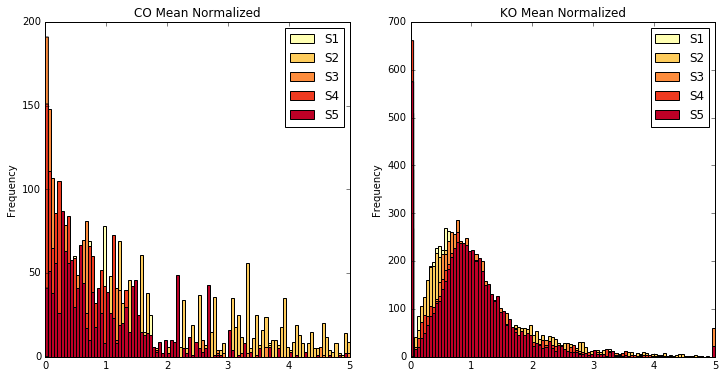

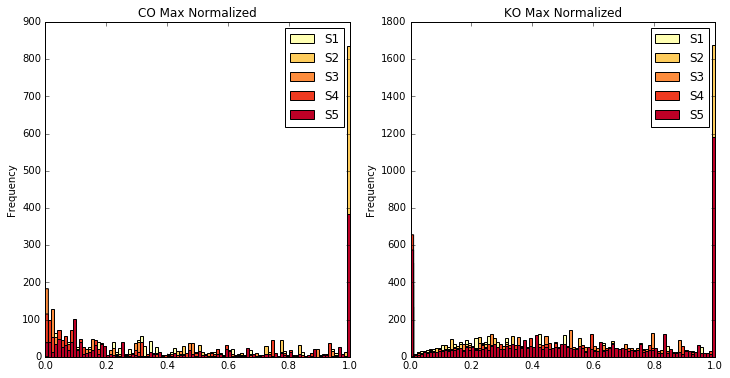

In [19]:
#original plotting
if True:

    #several options for normalizing the data
    CO_Norm2Mean=NormalizeToMean(CO_RawData_pruned) #this is what gets used in the original code
    KO_Norm2Mean=NormalizeToMean(KO_RawData) #this is what gets used in the original code
    CO_Norm2Max=NormalizeToMax(CO_RawData_pruned)
    KO_Norm2Max=NormalizeToMax(KO_RawData)

    cmap=pal.colorbrewer.sequential.YlOrRd_5.get_mpl_colormap()

    fig, axs=plt.subplots(1,2) 
    fig.set_size_inches(12,6)

    kplt=KO_Norm2Mean.plot(kind='hist', bins=100, title='KO Mean Normalized', colormap=cmap, ax=axs[1])
    cplt=CO_Norm2Mean.plot(kind='hist', bins=100, title='CO Mean Normalized', colormap=cmap, ax=axs[0])
    fig, axs=plt.subplots(1,2) 
    fig.set_size_inches(12,6)

    kplt=KO_Norm2Max.plot(kind='hist', bins=100, title='KO Max Normalized', colormap=cmap, ax=axs[1])
    cplt=CO_Norm2Max.plot(kind='hist', bins=100, title='CO Max Normalized', colormap=cmap, ax=axs[0])

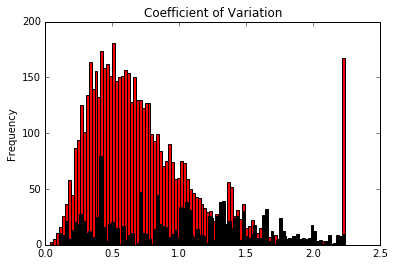

In [20]:
#could also try the normalize to mean, CV

cmap=pal.colorbrewer.diverging.PRGn_5.get_mpl_colormap()
fig,ax=plt.subplots(1)
CO_CV=NormalizeToMean_CV(CO_RawData_pruned)
KO_CV=NormalizeToMean_CV(KO_RawData)
# KO_CV.CV.plot(kind='hist', ax=ax, bins=100, title='CO Mean Normalized', colormap=cmap)
KO_CV.CV.plot(kind='hist', ax=ax, bins=100, color='r')
CO_CV.CV.plot(kind='hist', ax=ax, bins=100, title='Coefficient of Variation', color='k')
fig.savefig('Coefficent of Variation')


In [21]:
# KO_finalOption = KO_clr.loc[AllKO].dropna()
# CO_finalOption = CO_Norm2Mean.dropna() #already 'limited' this before the normalization

#will not do the clr normalization, but I like the _finalOption variable names
KO_finalOption = KO_Norm2Max.loc[AllKO].dropna()
CO_finalOption = CO_Norm2Max.dropna() #already 'limited' this before the normalization

In [22]:
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

#this next line prints up some sort of pre-canned details about the program. 
print(__doc__) 

def kmeanCluster(data,nc):
    #kmeans=KMeans(n_clusters=nc)
    kmeans = KMeans(n_clusters = nc, max_iter = 1000, n_init = 50, init = 'random')
    kmeans.fit(data)
    newData=data.copy()
    newData['kmeans']=kmeans.labels_
    return newData
def silhoetteAnalysis(X, range_n_clusters):
    ssa = [] #can I put the silhoette average here?
    # Generating the sample data from make_blobs
    # This particular setting has one distict cluster and 3 clusters placed close
    # together.
    for n_clusters in range_n_clusters:
        # Create a subplot with 1 row and 2 columns
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(18, 7)

        # The 1st subplot is the silhouette plot
        # The silhouette coefficient can range from -1, 1 but in this example all
        # lie within [-0.1, 1]
        ax1.set_xlim([-0.1, 1])
        # The (n_clusters+1)*10 is for inserting blank space between silhouette
        # plots of individual clusters, to demarcate them clearly.
        ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

        # Initialize the clusterer with n_clusters value and a random generator
        # seed of 10 for reproducibility.
        clusterer = KMeans(n_clusters=n_clusters, random_state=10)
        cluster_labels = clusterer.fit_predict(X)
        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed
        # clusters
        silhouette_avg = silhouette_score(X, cluster_labels)
        print("For n_clusters =", n_clusters,
              "The average silhouette_score is :", silhouette_avg)

        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(X, cluster_labels)

        y_lower = 10
       
        for i in range(n_clusters):
            # Aggregate the silhouette scores for samples belonging to
            # cluster i, and sort them
            ith_cluster_silhouette_values = \
                sample_silhouette_values[cluster_labels == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.spectral(float(i) / n_clusters)
            ax1.fill_betweenx(np.arange(y_lower, y_upper),
                              0, ith_cluster_silhouette_values,
                              facecolor=color, edgecolor=color, alpha=0.7)

            # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        # The vertical line for average silhoutte score of all the values
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

        # 2nd Plot showing the actual clusters formed
        colors = cm.spectral(cluster_labels.astype(float) / n_clusters)
         #ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7, c=colors)

        # Labeling the clusters
        centers = clusterer.cluster_centers_
        # Draw white circles at cluster centers
        ax2.scatter(centers[:, 0], centers[:, 1],
                    marker='o', c="white", alpha=1, s=200)

        for i, c in enumerate(centers):
            ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50)

        ax2.set_title("The visualization of the clustered data.")
        ax2.set_xlabel("Feature space for the 1st feature")
        ax2.set_ylabel("Feature space for the 2nd feature")

        plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                      "with n_clusters = %d" % n_clusters),
                     fontsize=14, fontweight='bold')
        plt.show()
    
def PlotKmeans(KmeansPD, kSize=10, figSizeX=1, figSizeY=5, color='k'):
    KmeansPD['kmeans'].plot(kind='hist', bins=kSize, color=color)
    fig,axs=plt.subplots(figSizeX, figSizeY)
    axs=[item for sublist in axs for item in sublist]
    fig.set_size_inches(9,12)
    for ax, y in zip(axs,range(kSize)):
        pltData=KmeansPD[KmeansPD.kmeans==y].T.drop('kmeans')
        pltData.plot(ax=ax, legend=False, grid=False, color=color)


Automatically created module for IPython interactive environment


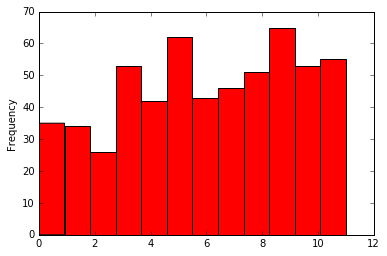

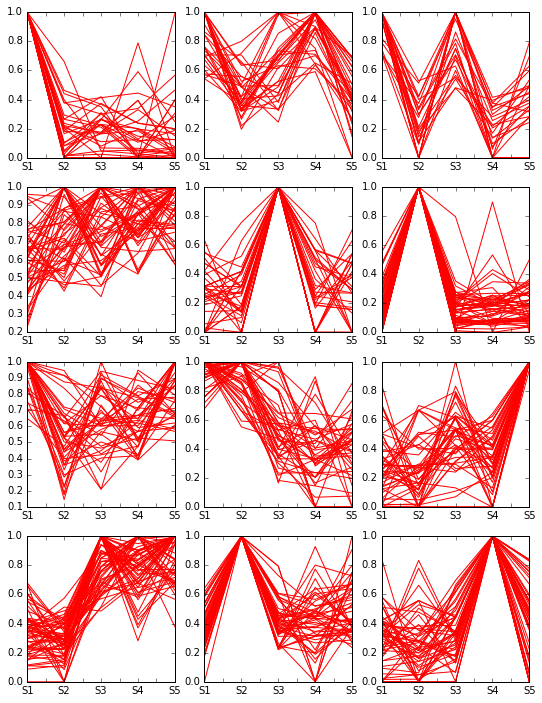

In [23]:
#run the Kmeans clustering on the KO data along first and plot results
#koClust=kmeanCluster(KO_limited_Norm2Mean, 15)
#PlotKmeans(koClust,15,3,5, 'r') 
koClust=kmeanCluster(KO_finalOption, 12)
PlotKmeans(koClust,12,4,3, 'r') 

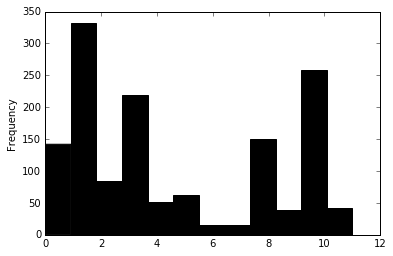

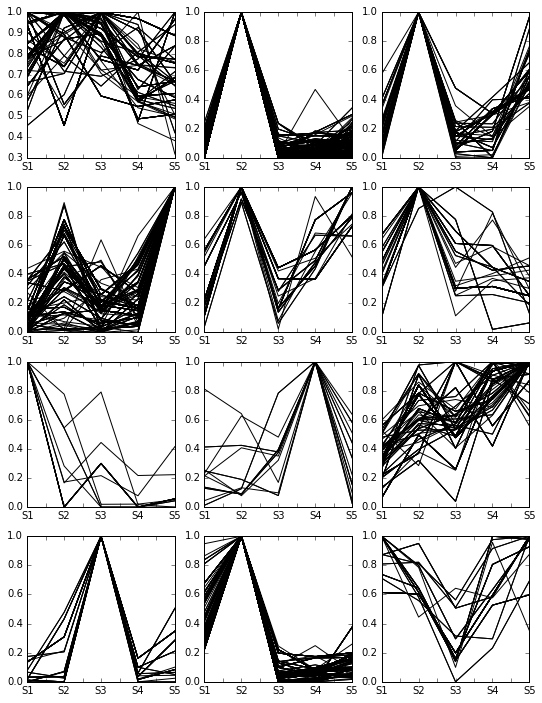

In [24]:
#plot up the results of one number of clusters for the CO data only
#coClust=kmeanCluster(CO_limited_Norm2Mean, 15)
#PlotKmeans(coClust,15,3,5, 'k') 
coClust=kmeanCluster(CO_finalOption.loc[:,(dayList)], 12)
PlotKmeans(coClust,12,4,3, 'k') 

From HA: By normalizing the data to the mean we can then (in theory) combine the two and cluster them together?
KL 8/20/2015 note: this is essentially a list with the CO and KO concatenated into a single data frame. Note that the actual kmeans clustering does not happen until after the silhoette analysis (bc need to set # clusters) and are using the silhouette analysis to do that.

#Do Kmeans on combined CO and KO data

In [25]:
##First, combine the CO and the KO data
#Combined_KO_CO_MeanNorm=KO_limited_Norm2Mean.append(CO_limited_Norm2Mean)
Combined_KO_CO_final=KO_finalOption.append(CO_finalOption.loc[:,(dayList)])

('For n_clusters =', 4, 'The average silhouette_score is :', 0.43369053909618138)


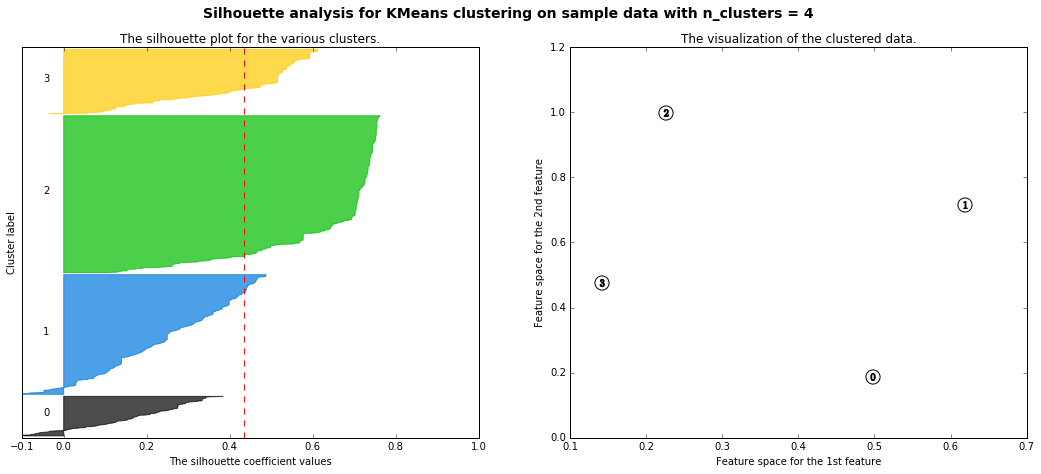

('For n_clusters =', 5, 'The average silhouette_score is :', 0.4300116198906101)


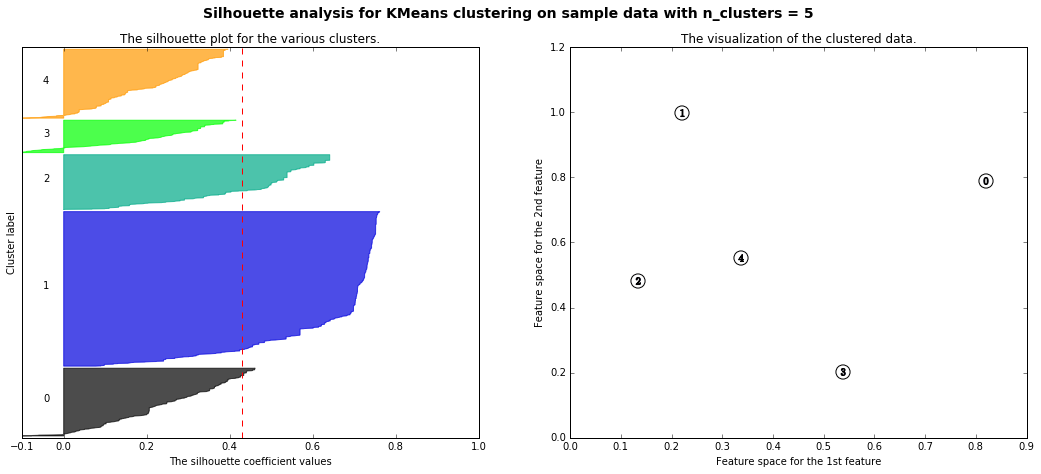

('For n_clusters =', 6, 'The average silhouette_score is :', 0.44385444586710804)


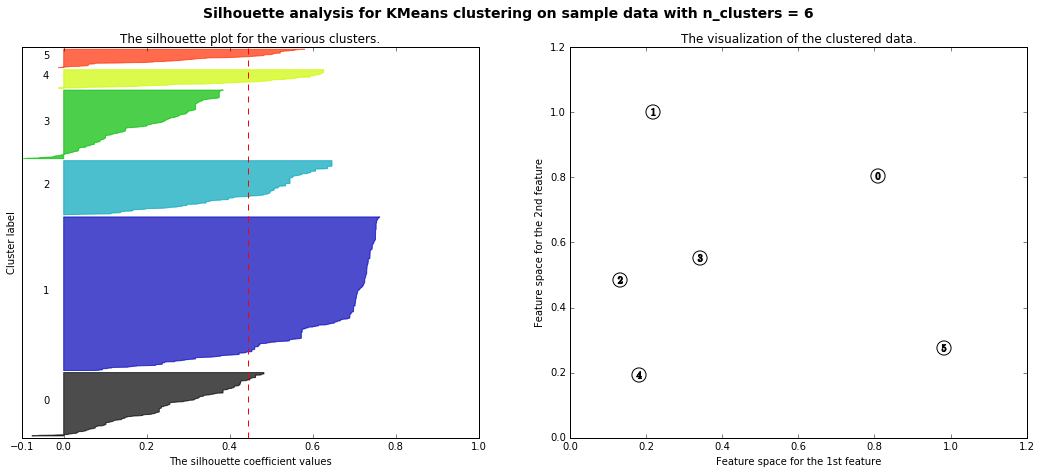

In [26]:
#Run silhoette analysis on a range of cluster options
silhoetteAnalysis(Combined_KO_CO_final, np.arange(4,7,1))

#keep these plots in here to remind me what the silhouette score is plotting up.

In [27]:
#go back to Kmeans and finding the right group

In [28]:
filename = 'nClustersRequired.py'
%run $filename

In [29]:
#cheat for the moment...save the data for the data I have as a CSV file and then read it in.
#figure out the format later.
dataFilename = 'NB_combined_for_kmeans.csv'
Combined_KO_CO_final.to_csv(dataFilename)

data = Data(dataFilename)
#pattern_labels are the rows...for us this will the RInumber
pattern_labels = []
patterns_data, pattern_labels = data.load_data()


In [30]:
def forest_run(dimensions, patterns, pattern_labels, metric='qe', fNamePrefix = '', k_up=20, k_down=2, simulations=55, iterations=50):
    """
    A method for watching Forest Gump run
    :param dimensions: the dimensionality of the data
    :param patterns: the data itself
    :param metric: the quality metric
    :fNamePrefix: put text in here if I want to add a unique prefix to the data file spit out at end
    :param k_up: the maximum number of clusters
    :param k_down: the minimum number of clusters
    :param simulations: the number of simulations for each k
    :param iterations: the number of iterations for each k-means pass
    """
    # variable to store the best result
    best_clustering = None
    # the quality of that result
    best_quality = 1000.00
    # write results out to file while simulating
    file_out = fNamePrefix + 'MonteCarloFinalResults' + '_' + metric + '.csv'
    #with open(file_out, 'w', newline='') as f: #newline doesn't work here
    with open(file_out,'w') as f:
        # different k values to test on
        for i in range(k_down, k_up):
            num_clusters = i
            # number of retries / simulations
            print('working on ' , i, '# of kmeans groups') #works, but doesn't look as I intended.
            
            for j in range(simulations):
                # create a clustering solution and apply k-means
                clustering = Clustering(dimensions, num_clusters, patterns, 0.0001)
                clustering.k_means_clustering(iterations)
                # used to compute quality of the solution
                quality = ClusteringQuality(clustering, 0.0001)
                this_quality = 0.0
                if metric == 'qe':
                    this_quality = quality.quantization_error()
                if metric == 'si':
                    this_quality = quality.average_silhouette_index()
                if metric == 'db':
                    this_quality = quality.davies_bouldin()
                # update the best clustering
                if this_quality < best_quality:
                    best_quality = this_quality
                    best_clustering = clustering
                    #print("Updated best clustering") #comment out, clogging up display
                # write result to the file
                result = [num_clusters, this_quality]
                for x in result:
                    f.write(str(x))
                    f.write(",")
                f.write("\n")
                f.flush()
                #print(j, result) #comment out, clogging up display
                
        # print the actual clustering out to console...comment this out, too much information
        #best_clustering.print_solution(pattern_labels)

In [31]:
dimensions = 5 #this is a function of the data itself. In the NB data we have five sampling days.
setSimulations = 100
setIterations = 100 #this is the default from the Turing Finance code
setKup = 20
setKdown = 2

In [32]:
#for now, comment out the forest_run in the next three cells...that is time consuming

#

In [33]:
prefix = 'KO_norm2max_'
forest_run(dimensions, patterns_data, pattern_labels, metric='db', fNamePrefix = prefix,
       simulations=setSimulations, k_down=setKdown, k_up=setKup, iterations = setIterations)

#read in the results
riScores_db=pd.read_csv((prefix + 'MonteCarloFinalResults_db.csv'),header=None,delimiter=',',
                index_col=False,names=['nClusters', 'score'])

#optimal cluster solution has the smallest Davies-Bouldin index

('working on ', 2, '# of kmeans groups')
('working on ', 3, '# of kmeans groups')
('working on ', 4, '# of kmeans groups')
('working on ', 5, '# of kmeans groups')
('working on ', 6, '# of kmeans groups')
('working on ', 7, '# of kmeans groups')
('working on ', 8, '# of kmeans groups')
('working on ', 9, '# of kmeans groups')
('working on ', 10, '# of kmeans groups')
('working on ', 11, '# of kmeans groups')
('working on ', 12, '# of kmeans groups')
('working on ', 13, '# of kmeans groups')
('working on ', 14, '# of kmeans groups')
('working on ', 15, '# of kmeans groups')
('working on ', 16, '# of kmeans groups')
('working on ', 17, '# of kmeans groups')
('working on ', 18, '# of kmeans groups')
('working on ', 19, '# of kmeans groups')


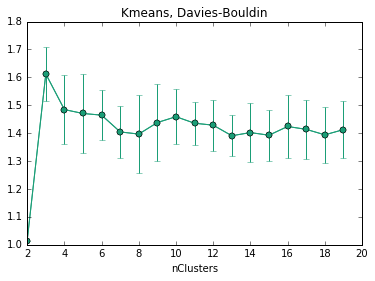

In [34]:
grouped = riScores_db.groupby('nClusters')
means = grouped.mean().unstack()
errors = grouped.std().unstack()
fig, ax = plt.subplots()
plt.plot(range(setKdown,setKup),means,marker = 'o',color = '#1b9e77')
plt.errorbar(range(setKdown,setKup),means,errors,marker = 'o',color = '#1b9e77')
plt.title('Kmeans, Davies-Bouldin')
ax.set_xlabel('nClusters')
plt.show()

In [35]:
prefix = 'KO_norm2max_'
forest_run(dimensions, patterns_data, pattern_labels, metric='qe', fNamePrefix = prefix,
       simulations=setSimulations, k_down=setKdown, k_up=setKup, iterations = setIterations)

#now read in the results
riScores_qe=pd.read_csv((prefix + 'MonteCarloFinalResults_qe.csv'),header=None,delimiter=',',
                index_col=False,names=['nClusters', 'score'])

('working on ', 2, '# of kmeans groups')
('working on ', 3, '# of kmeans groups')
('working on ', 4, '# of kmeans groups')
('working on ', 5, '# of kmeans groups')
('working on ', 6, '# of kmeans groups')
('working on ', 7, '# of kmeans groups')
('working on ', 8, '# of kmeans groups')
('working on ', 9, '# of kmeans groups')
('working on ', 10, '# of kmeans groups')
('working on ', 11, '# of kmeans groups')
('working on ', 12, '# of kmeans groups')
('working on ', 13, '# of kmeans groups')
('working on ', 14, '# of kmeans groups')
('working on ', 15, '# of kmeans groups')
('working on ', 16, '# of kmeans groups')
('working on ', 17, '# of kmeans groups')
('working on ', 18, '# of kmeans groups')
('working on ', 19, '# of kmeans groups')


In [36]:
#goal is to minimize quantization error. QE is the distance between a sample
#and its representation. Lower quantization errors represent a good data cluster.

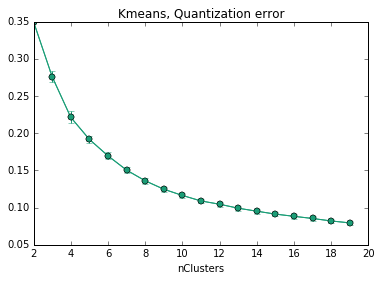

In [37]:
grouped = riScores_qe.groupby('nClusters')
means = grouped.mean().unstack()
errors = grouped.std().unstack()
fig, ax = plt.subplots()
plt.plot(range(setKdown,setKup),means,marker = 'o',color = '#1b9e77')
plt.errorbar(range(setKdown,setKup),means,errors,marker = 'o',color = '#1b9e77')
plt.title('Kmeans, Quantization error')
ax.set_xlabel('nClusters')
plt.show()

In [38]:
##silhouette is really slow cfd to the other
prefix = 'KO_norm2max_'

# #silhouette is quite slow cfd to the other two metrics
forest_run(dimensions, patterns_data, pattern_labels, metric='si', fNamePrefix = prefix,
           simulations=setSimulations, k_down=setKdown, k_up=setKup, iterations = setIterations)

riScores_si=pd.read_csv((prefix + 'MonteCarloFinalResults_si.csv'),header=None,delimiter=',',
                index_col=False,names=['nClusters', 'score'])


##note, want to maximize the silhouette value for each pattern in the dataset

('working on ', 2, '# of kmeans groups')
('working on ', 3, '# of kmeans groups')
('working on ', 4, '# of kmeans groups')
('working on ', 5, '# of kmeans groups')
('working on ', 6, '# of kmeans groups')
('working on ', 7, '# of kmeans groups')
('working on ', 8, '# of kmeans groups')
('working on ', 9, '# of kmeans groups')
('working on ', 10, '# of kmeans groups')
('working on ', 11, '# of kmeans groups')
('working on ', 12, '# of kmeans groups')
('working on ', 13, '# of kmeans groups')
('working on ', 14, '# of kmeans groups')
('working on ', 15, '# of kmeans groups')
('working on ', 16, '# of kmeans groups')
('working on ', 17, '# of kmeans groups')
('working on ', 18, '# of kmeans groups')
('working on ', 19, '# of kmeans groups')


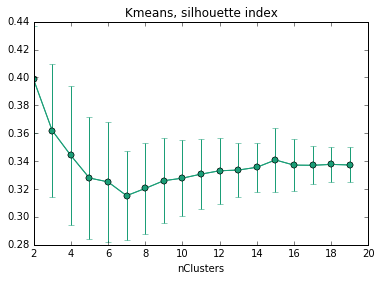

In [39]:
grouped = riScores_si.groupby('nClusters')
means = grouped.mean().unstack()
errors = grouped.std().unstack()
fig, ax = plt.subplots()
plt.plot(range(setKdown,setKup),means,marker = 'o',color = '#1b9e77')
plt.errorbar(range(setKdown,setKup),means,errors,marker = 'o',color = '#1b9e77')
plt.title('Kmeans, silhouette index')
ax.set_xlabel('nClusters')
plt.show()

#remember, want to maximize this value

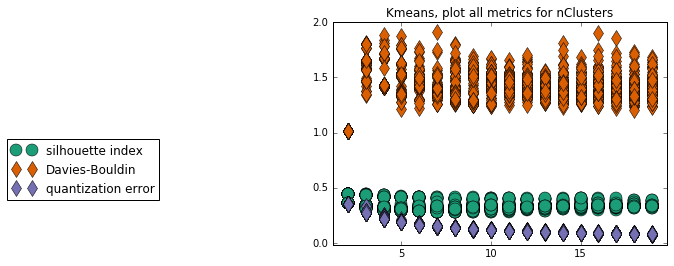

In [40]:
#now that I have all three metrics done and results are in python, make one plot with all of them
# riScores_si
# riScores_db
# riScores_qe

# Plot
fig, ax = plt.subplots()
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
ax.plot(riScores_si.nClusters,riScores_si.score,marker = 'o',linestyle='',ms=12,color = '#1b9e77')
ax.plot(riScores_db.nClusters,riScores_db.score,marker = 'd',linestyle='',ms=12,color = '#d95f02')
ax.plot(riScores_qe.nClusters,riScores_qe.score,marker = 'd',linestyle='',ms=12,color = '#7570b3')

fL = ['silhouette index','Davies-Bouldin','quantization error']
leg = ax.legend(fL,bbox_to_anchor=([-0.5, 0.5]))

plt.title('Kmeans, plot all metrics for nClusters')
plt.show()

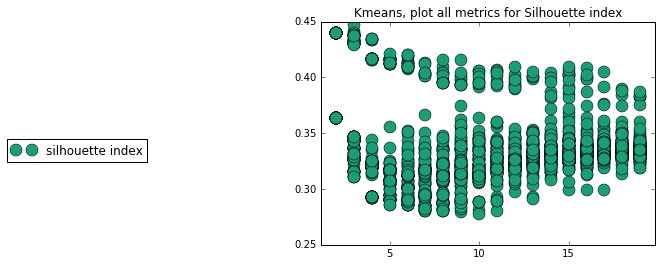

In [41]:
#hard to see with all three on one plot, try plotting individually
fig, ax = plt.subplots()
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
ax.plot(riScores_si.nClusters,riScores_si.score,marker = 'o',linestyle='',ms=12,color = '#1b9e77')

fL = ['silhouette index']
leg = ax.legend(fL,bbox_to_anchor=([-0.5, 0.5]))

plt.title('Kmeans, plot all metrics for Silhouette index')
plt.ylim(0.25 ,0.45)
plt.show()

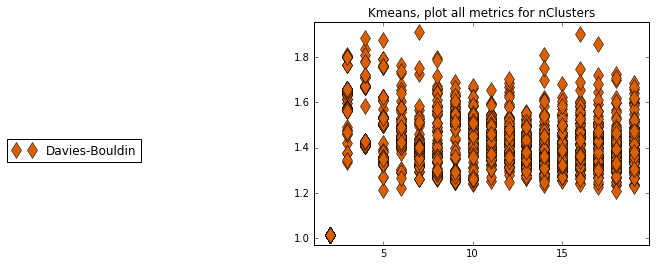

In [42]:
fig, ax = plt.subplots()
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
ax.plot(riScores_db.nClusters,riScores_db.score,marker = 'd',linestyle='',ms=12,color = '#d95f02')

fL = ['Davies-Bouldin']
leg = ax.legend(fL,bbox_to_anchor=([-0.5, 0.5]))

plt.title('Kmeans, plot all metrics for nClusters')
plt.show()

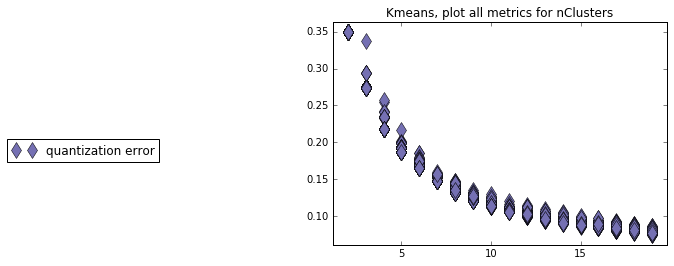

In [43]:
fig, ax = plt.subplots()
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
ax.plot(riScores_qe.nClusters,riScores_qe.score,marker = 'd',linestyle='',ms=12,color = '#7570b3')

fL = ['quantization error']
leg = ax.legend(fL,bbox_to_anchor=([-0.5, 0.5]))

plt.title('Kmeans, plot all metrics for nClusters')
plt.show()

#Move forward with 'best' number of clusters

In [44]:
#setting # of clusters manually, also some good options with lower # of clusters I think
#this number will get used later when plotting up the BRITE categories and the Kmeans clusters
makeNclusters = 6

In [45]:
#do the K-means clustering with the final # of clusters
CcoClust=kmeanCluster(Combined_KO_CO_final, makeNclusters) #was 18 

#this will result in a data frame with the kmeans cluster as an added column. Remember
#this will have RI numbers for the compounds

In [46]:
CcoClust.head(5)

,S1,S2,S3,S4,S5,kmeans
K00509,0.034285,1.000000,0.028139,0.023880,0.037741,4
K00503,0.297268,0.958599,0.566175,0.763612,1.000000,3
K00500,0.177719,1.000000,0.246148,0.197792,0.701072,4
K00505,1.000000,0.591468,0.571604,0.358453,0.517758,0
K01101,0.141872,0.235068,0.278700,1.000000,0.267507,3


In [47]:
CcoClust.tail(5)

,S1,S2,S3,S4,S5,kmeans
RI4917,0.071174,1,0.137375,0.022574,0.000000,4
RI4924,0.106716,1,0.237244,0.233295,0.561021,4
RI4925,0.099310,1,0.150044,0.195953,0.375701,4
RI4930,0.106716,1,0.237244,0.233295,0.561021,4
RI4931,0.099310,1,0.150044,0.195953,0.375701,4


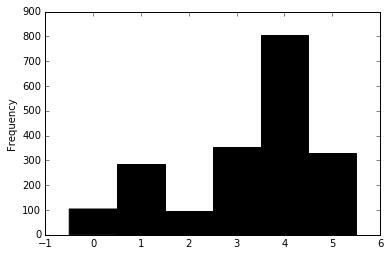

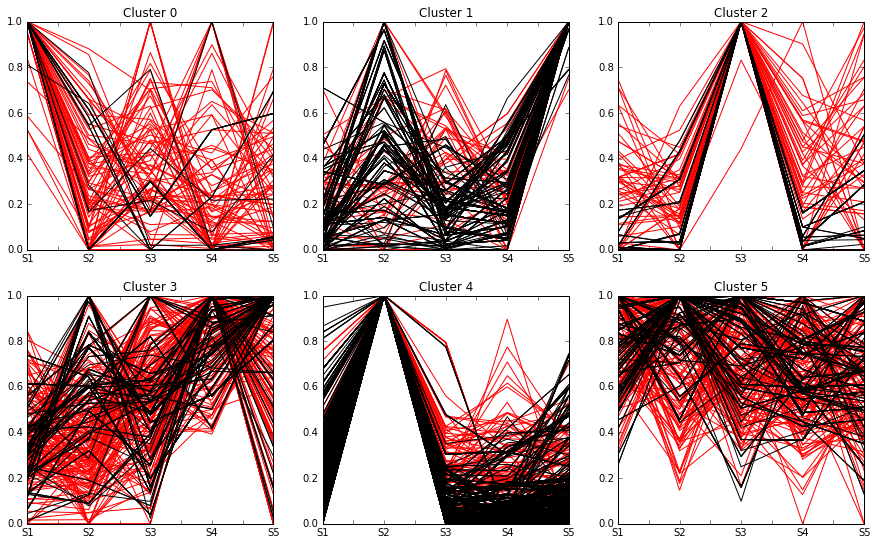

In [71]:
def PlotKmeansCombined(KmeansPD, kSize=10, figSizeX=1, figSizeY=5, color='k'):
    KmeansPD['kmeans'].plot(kind='hist', bins=kSize, color='k',range = (0,kSize),align = 'left')
    fig,axs=plt.subplots(figSizeX, figSizeY)
    axs=[item for sublist in axs for item in sublist]
    fig.set_size_inches(15,9)
    i=KmeansPD.index
    i=list(i)
    Ks=re.compile('K.*')
    #Cs=re.compile('C.*')
    Cs = re.compile('R.*') #this is the RInumber I created...for the moment, do not need the Cnumber
    C = filter(Cs.search, i)  
    K = filter(Ks.search, i)  
    Ksplit=KmeansPD.loc[K]
    Csplit=KmeansPD.loc[C]
    for ax, y in zip(axs,range(kSize)):
        KData=Ksplit[Ksplit.kmeans==y].T.drop('kmeans')
        KData.plot(ax=ax, legend=False, grid=False, color='r')
        CData=Csplit[Csplit.kmeans==y].T.drop('kmeans')
        CData.plot(ax=ax, legend=False, grid=False, color='k')
        SumKC=len(KData.T)+len(CData.T)
        KPct=float(len(KData.T))/SumKC*100
        CPct=float(len(CData.T))/SumKC*100
        #ax.set_title('Cluster ' + str(y)+ ', ' + str(round(KPct,2))+'% Genes')
        ax.set_title('Cluster ' + str(y))
        ax.set_ylim([0,1])
    fig.savefig('CombinedKOandCO_Kmeans')

PlotKmeansCombined(CcoClust,makeNclusters,2,3, 'r') 

##plot up the data..just a few here as a reminder of where we are heading

In [49]:
#this setups up forPlotting as one, pre-defined Kmeans group
forPlotting = CcoClust[CcoClust.kmeans==5]

In [50]:
forPlotting.shape
#literally put this here to slow down the notebook...I think it is a problem with the
#notebook not finishing up the image plotting before moving on...

(331, 6)

Odd. Sometimes it seems that iPython notebook moves to the next cell before finishing the last one. When this happens, I get empty images? And empty matches...
...later note, I think this is because the notebook works on different cells in parallel

In [51]:
#this gets around the timing problem.
import time
time.sleep(60)

In [52]:
#Start with the simple version
noMatch = []
#will use counter to limit the number of plots, remember skipping over KOnumbers 
#so index would require some guessing as to where the CO plots start
counter = 1 
for i,RI in enumerate(forPlotting.index):
    if counter < 5:
#     if (i >38) & (i < 40):
        if RI[0] == 'R':
            #have an RInumber, go get the Cnumber
            CO = convertRItoCO(CO_fromMATLAB,RI)
            
            #pull the Kmeans group for the title [presumably there is a one-liner for this]
            fT = str(forPlotting.ix[i, 'kmeans'])
            Kg = fT.rstrip('.0') #why isn't this working?
            
            #there will be multiple (and varied) related KOs and COs
            try:
                kos=CO_withKO[CO]['Related KO']
                cos=CO_withKO[CO]['Related CO'] 

                #the kData are easy to process
                for k in kos: 
                    if k in forPlotting.index: 
                        kData=forPlotting.ix[kos,dayList].dropna()
                        kData=(kData.T/kData.sum(axis=1)).T

                #match the cos here with the RInumbers I generated
                tData = [];
                for c in cos:
                    m = findRInumber(forRelatedness,c)
                    if len(m)!=0: #seems dumb, looking for an isempty equivalent since I don't want the nones here
                        tData.append(m)

                #flatten the list...since I don't need the different groups generated by the previous cell
                tData = list(chain.from_iterable(tData))

                cData=forPlotting.ix[tData,dayList].dropna()
                cData=(cData.T/cData.sum(axis=1)).T

                fig, ax=plt.subplots(1)
                kData.T.plot(color='r', ax=ax)
                cData.T.plot(color='k', ax=ax)

                handles, labels = ax.get_legend_handles_labels()
                #convert the RI numbers to COnumbers for the figure
                for ia, a in enumerate(labels):
                    if a[0]=='R':
                        m = convertRItoCO(CO_fromMATLAB,a)
                        labels[ia] = m
                        #print i, m

                ax.legend(handles, labels)        
                fig.suptitle(CO + ' normalized data, Kmeans grp. ' + str(fT))
                #fig.savefig(CO+'.png')
                counter = counter + 1
            except:
                #figure out later why some of these don't have a match
                noMatch.append(CO)

###focus on things with common linked reactions...

In [53]:
#But...for the CheckRelatedness...do need to go back to the cNumber...
#for now, easiest to just make yet another matrix and put the cNumbers back in.
forRelatedness = CcoClust.copy(deep=True) #make a copy of the CcoClust data frame
forRelatedness.insert(0,'KEGG',"") #add a column called 'KEGG'
forRelatedness.head(5)

,KEGG,S1,S2,S3,S4,S5,kmeans
K00509,,0.034285,1.000000,0.028139,0.023880,0.037741,4
K00503,,0.297268,0.958599,0.566175,0.763612,1.000000,3
K00500,,0.177719,1.000000,0.246148,0.197792,0.701072,4
K00505,,1.000000,0.591468,0.571604,0.358453,0.517758,0
K01101,,0.141872,0.235068,0.278700,1.000000,0.267507,3


In [54]:
for idx in range(0,len(forRelatedness)):
    t = forRelatedness.iloc[idx,:].name

    if t[0]=='R':
        #go find the matching cNumber in CO_RawData_all
        t2 = CO_fromMATLAB.loc[t,('cNumber')]
        forRelatedness.ix[idx,('KEGG')] = t2
    elif t[0] == 'K':
        #just copy the K number over
        forRelatedness.ix[idx,('KEGG')] = t

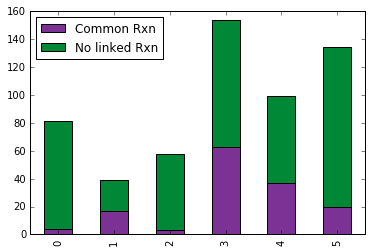

In [55]:
def CheckRelatedness(inClust,nC):
    df=pd.DataFrame(columns=['Common Rxn','No linked Rxn'], index=range(nC))
    for n in range(nC):
        kClust=inClust[inClust.kmeans==n]
        #i=kClust.index
        i = kClust.KEGG #change the new column I created with Cnumbers and Knumbers
        i=list(i)
        #note...re is one of the things imported at the very beginning
        Csearc=re.compile('C.*') #re is regular expression...perl-like; re.compile bascially makes an object 
        Cs = filter(Csearc.search, i)
        Ksearc=re.compile('K.*')
        Kis = filter(Ksearc.search, i)
        Kis=set(Kis)
        Ks=[]
        for c in Cs:
            if c in CO_withKO.keys():
                Ks.append(CO_withKO[c]['Related KO'])
        Ks=set([item for sublist in Ks for item in sublist])
        df.loc[n,'Common Rxn']=len(Kis.intersection(Ks))
        df.loc[n, 'No linked Rxn']=len(Kis)-len(Kis.intersection(Ks))
    df.plot(kind='bar', stacked=True, colormap=pal.colorbrewer.diverging.PRGn_5.get_mpl_colormap(), grid=False)
     
CheckRelatedness(forRelatedness, makeNclusters)

pick up here to change to using biopython module to get maps with merged KO and CO data within a K means group
12 November 2015

In [56]:
forRelatedness.head(5)

,KEGG,S1,S2,S3,S4,S5,kmeans
K00509,K00509,0.034285,1.000000,0.028139,0.023880,0.037741,4
K00503,K00503,0.297268,0.958599,0.566175,0.763612,1.000000,3
K00500,K00500,0.177719,1.000000,0.246148,0.197792,0.701072,4
K00505,K00505,1.000000,0.591468,0.571604,0.358453,0.517758,0
K01101,K01101,0.141872,0.235068,0.278700,1.000000,0.267507,3


In [57]:
forRelatedness.tail(5)

,KEGG,S1,S2,S3,S4,S5,kmeans
RI4917,C04145,0.071174,1,0.137375,0.022574,0.000000,4
RI4924,C06218,0.106716,1,0.237244,0.233295,0.561021,4
RI4925,C06218,0.099310,1,0.150044,0.195953,0.375701,4
RI4930,C06218,0.106716,1,0.237244,0.233295,0.561021,4
RI4931,C06218,0.099310,1,0.150044,0.195953,0.375701,4


In [58]:
from Bio import SeqIO
from Bio.KEGG.REST import *
from Bio.KEGG.KGML import KGML_parser
from Bio.Graphics.KGML_vis import KGMLCanvas
from Bio.Graphics.ColorSpiral import ColorSpiral

from IPython.display import Image, HTML

# import random #seems like I can probably skip this, but just comment out in case that is not true

# A bit of code that will help us display the PDF output
def PDF(filename):
    return HTML('<iframe src=%s width=700 height=350></iframe>' % filename)

# A bit of helper code to shorten long text
def head(text, lines=10):
    """ Print the first lines lines of the passed text.
    """
    print '\n'.join(text.split('\n')[:lines] + ['[...]'])

In [59]:
#set up a function to get the list of K orthologues for a given pathway (must be defined as ko00140 NOT map00140)
def getKfrom_ko(ko_id):
    pathway_file = kegg_get(ko_id).read()  # query and read the pathway
    K_list = []

    current_section = None
    for line in pathway_file.rstrip().split("\n"):
        section = line[:12].strip()  # section names are within 12 columns
        if not section == "":
            current_section = section
        if current_section == "ORTHOLOGY":
            K_identifiers = line[12:].split("; ")
            t = K_identifiers[0]
            K_id = t[0:6]

            if not K_id in K_list:
                K_list.append(K_id)
    return K_list

In [60]:
#set up a function to get the list of compounds for a given pathway (must be defined as ko00140 NOT map00140)
def getCfrom_ko(ko_id):
    pathway_file = kegg_get(ko_id).read()  # query and read the pathway
    compound_list = []

    current_section = None
    for line in pathway_file.rstrip().split("\n"):
        section = line[:12].strip()  # section names are within 12 columns
        if not section == "":
            current_section = section
        if current_section == "COMPOUND":
            compound_identifiers = line[12:].split("; ")
            t = compound_identifiers[0]
            compound_id = t[0:6]

            if not compound_id in compound_list:
                compound_list.append(compound_id)
    return compound_list

In [61]:
allPathways = kegg_list("pathway").read()

In [62]:
len(allPathways.split('\n'))

481

In [63]:
#so, 480 pathways at KEGG, not all of which are likely to be interesting.

In [95]:
trimPath = []
current_section = None
for line in allPathways.rstrip().split("\n"):
#     Tracer()()
    tp = line[8:13]
    
    trimPath.append('ko' + tp)

In [96]:
#have some cases where KEGG will send back a pathway, but the pathway itself is not searchable...seems to 
#be a KEGG bug, 'ko00351',
#did this list manually since I thought it would be short...
toDelete = ('ko00351','ko01010','ko01060', 'ko01061',  'ko01062', 'ko01063', 'ko01064', 'ko01065', 'ko01066',
 'ko01070', 'ko07011', 'ko07012', 'ko07013', 'ko07014', 'ko07015', 'ko07016', 'ko07017', 'ko07018', 'ko07019',
 'ko07020', 'ko07021', 'ko07023', 'ko07024', 'ko07025', 'ko07026', 'ko07027', 'ko07028', 'ko07029', 'ko07030',
 'ko07031', 'ko07032', 'ko07033', 'ko07034', 'ko07035', 'ko07036', 'ko07037', 'ko07038', 'ko07039', 'ko07040',
 'ko07041', 'ko07042', 'ko07043', 'ko07044', 'ko07045', 'ko07046', 'ko07047', 'ko07048', 'ko07049', 'ko07050',
 'ko07051', 'ko07052', 'ko07053', 'ko07054', 'ko07055', 'ko07056', 'ko07057', 'ko07110', 'ko07112', 'ko07114',
 'ko07117', 'ko07211', 'ko07212', 'ko07213', 'ko07214', 'ko07215', 'ko07216', 'ko07217', 'ko07218', 'ko07219',
 'ko07220', 'ko07221', 'ko07222', 'ko07223', 'ko07224', 'ko07225', 'ko07226', 'ko07227', 'ko07228', 'ko07229',
 'ko07230', 'ko07231', 'ko07232', 'ko07233', 'ko07234', 'ko07235','ko04933')

In [97]:
#probably a way to do this without the for loop, but this will work
for item in toDelete:
    trimPath.remove(item)

In [107]:
#preset the colors, '#f7f7f7' is white
#useColors = ('#c2a5cf','#7b3294','#f7f7f7','#008837','#a6dba0')
# useColors = ('#7b3294','#c2a5cf','#f7f7f7','#a6dba0','#008837')
#useColors = ('#1b9e77','#d95f02','#f7f7f7','#e7298a','#7570b3')
useColors = ('#e41a1c','#377eb8','#f7f7f7','#4daf4a','#984ea3') #[red,blue,white,green,purple]

#this might be a better option:
#[dk red, pale orange, white, dk blue, light blue]
#useColors = ('#ca0020','#f4a582','#f7f7f7','#0571b0','#92c5de') 

In [108]:
colLabel = ['nCpds','nGenes','nCpdsFound','nGenesFound'] #starting with this is easiest - makes one list, no need to flatten

for item in range(makeNclusters):
    colLabel.append('Km' + str(item) + '_cpd')
    colLabel.append('Km' + str(item) + '_gene')
    
gatherCounts = pd.DataFrame(0, index = trimPath, columns = colLabel)

In [105]:
#us this to figure out where the ko number search fails - KEGG has apparently assigned some pathways numbers,
#but there is no information available for them.
if False:
    for item in trimPath:
        r = getKfrom_ko(item)
        print item

In [109]:
for kn in range(makeNclusters):
# for kn in range(5,6):
# for kn in range(1):    
    
    fullSet = set(forRelatedness.KEGG)
    oneK = forRelatedness[forRelatedness.kmeans == kn] #get gene & transcript information for one Kmeans group
    getKm = 'Km' + str(kn)
    
    #check if a directory exists for PDF files
    directory = 'Kmeans_' + str(kn) + '_PDFfiles'
    if not os.path.exists(directory):
        os.makedirs(directory)

    for item in trimPath:
        genes = getKfrom_ko(item)
        compounds = getCfrom_ko(item)
        
        gatherCounts.loc[item,'nCpds'] = len(compounds)
        gatherCounts.loc[item,'nGenes'] = len(genes)
        
        
        #have to track genes and compounds differently for the biopython plotting later on 
        setG = set(genes)
        setC = set(compounds)
        setB = set(oneK.KEGG)
        intGenes = setG.intersection(setB)
        intCompounds = setC.intersection(setB)

        gatherCounts.loc[item,(getKm + '_gene')] = len(intGenes)
        gatherCounts.loc[item,(getKm + '_cpd')] = len(intCompounds)

        
        if intGenes and intCompounds:
            #get the pathway information for the picture [need this to get the handles for the graphics]
            pathway = KGML_parser.read(kegg_get(item, "kgml"))

            for element in pathway.orthologs:
                #print element.name
                for graphic in element.graphics:
                    tg = element.name[3:9] #skip over the 'ko:'

                    if (tg in intGenes):
                        #in the pathway AND in the set for this particular K means group
                        graphic.bgcolor = useColors[0] #red

                    elif (tg in fullSet) and (tg in genes) and (tg not in intGenes):
                        #in the pathway AND in the set of genes from RI, but *not* in this Kmeans group
                        graphic.bgcolor = useColors[1] #blue

                    elif (tg not in fullSet) and (tg in genes):
                        #in the pathway, but *not* in anything from the RI samples
                        graphic.bgcolor = useColors[2] #white

            # Change the colours of compounds
            for element in pathway.compounds:
                for graphic in element.graphics:
                    tc = element.name[4:10] #skip over the 'cpd:'

                    if (tc in intCompounds):
                        #in the pathway AND in the set for this particular K means group
                        graphic.bgcolor = useColors[3] #green

                    elif (tc in fullSet) and (tc in compounds) and (tc not in intCompounds):
                        #in the pathway AND in the set of compounds from RI, but *not* in this Kmeans group
                        graphic.bgcolor = useColors[4] #purple

                    elif (tc not in fullSet) and (tc in compounds):
                        #in the pathway, but *not* in anything from the RI samples
                        graphic.bgcolor = useColors[2] #white


            canvas = KGMLCanvas(pathway, import_imagemap=True)
            fName = 'mapWithColors_' + str(item) + '.pdf'
            canvas.draw(directory + '/' + fName)
            #PDF(fName) #comment this out to *not* see the PDF within the iPython notebook':


In [110]:
gatherCounts.loc['ko00591']

nCpds          28
nGenes         25
nCpdsFound      0
nGenesFound     0
Km0_cpd         0
Km0_gene        0
Km1_cpd         0
Km1_gene        0
Km2_cpd         4
Km2_gene        1
Km3_cpd         0
Km3_gene        0
Km4_cpd         3
Km4_gene        1
Km5_cpd         2
Km5_gene        2
Name: ko00591, dtype: int64

In [111]:
#go through and do the math: total # of genes found and total # of cpds found (add across columns)
#probably some multilevel indexing way to get around this...but leave for the moment
gatherCounts['sumCpds'] = gatherCounts['Km0_cpd'] + gatherCounts['Km1_cpd'] + gatherCounts['Km2_cpd'] + \
                            gatherCounts['Km3_cpd'] + gatherCounts['Km4_cpd'] + gatherCounts['Km5_cpd']

gatherCounts['percentCpds'] = gatherCounts['sumCpds'] / gatherCounts['nCpds']*100

gatherCounts['sumGenes'] = gatherCounts['Km0_gene'] + gatherCounts['Km1_gene'] + gatherCounts['Km2_gene'] + \
                            gatherCounts['Km3_gene'] + gatherCounts['Km4_gene'] + gatherCounts['Km5_gene']
    
gatherCounts['percentGenes'] = gatherCounts['sumGenes'] / gatherCounts['nGenes']*100

In [112]:
gatherCounts.head(10)


,nCpds,nGenes,nCpdsFound,nGenesFound,Km0_cpd,Km0_gene,Km1_cpd,Km1_gene,Km2_cpd,Km2_gene,Km3_cpd,Km3_gene,Km4_cpd,Km4_gene,Km5_cpd,Km5_gene,sumCpds,percentCpds,sumGenes,percentGenes
ko00010,31,93,0,0,0,1,1,0,0,1,0,5,3,2,0,5,4,12.903226,14,15.053763
ko00020,20,56,0,0,0,0,1,3,0,2,2,6,2,2,0,6,5,25.000000,19,33.928571
ko00030,35,75,0,0,0,1,0,0,0,0,0,1,2,0,0,1,2,5.714286,3,4.000000
ko00040,55,63,0,0,0,1,0,0,0,1,1,3,1,0,0,2,2,3.636364,7,11.111111
ko00051,53,98,0,0,2,2,0,0,0,3,4,2,11,1,2,3,19,35.849057,11,11.224490
ko00052,45,74,0,0,2,2,0,1,0,2,0,6,12,3,2,1,16,35.555556,15,20.270270
ko00053,47,44,0,0,0,3,1,2,0,1,2,5,5,0,0,2,8,17.021277,13,29.545455
ko00061,50,33,0,0,0,0,0,1,0,0,0,0,1,1,1,0,2,4.000000,2,6.060606
ko00062,40,23,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0.000000,1,4.347826
ko00071,50,53,0,0,0,1,1,1,0,1,0,4,0,2,0,3,1,2.000000,12,22.641509


In [113]:
gatherCounts.sort('percentGenes',inplace = True, ascending = False)

C:\Anaconda\lib\site-packages\ipykernel\__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


In [114]:
gatherCounts.head(10)

,nCpds,nGenes,nCpdsFound,nGenesFound,Km0_cpd,Km0_gene,Km1_cpd,Km1_gene,Km2_cpd,Km2_gene,Km3_cpd,Km3_gene,Km4_cpd,Km4_gene,Km5_cpd,Km5_gene,sumCpds,percentCpds,sumGenes,percentGenes
ko00290,23,17,0,0,0,7,10,0,0,2,4,1,0,1,2,1,16,69.565217,12,70.588235
ko00363,25,5,0,0,0,0,0,0,0,0,3,1,2,1,2,1,7,28.000000,3,60.000000
ko00983,49,22,0,0,0,3,0,1,0,1,1,3,0,2,0,2,1,2.040816,12,54.545455
ko00471,12,6,0,0,0,0,0,0,0,1,1,2,1,0,0,0,2,16.666667,3,50.000000
ko00770,28,36,0,0,0,3,3,1,0,2,1,5,0,2,1,4,5,17.857143,17,47.222222
ko00140,99,46,0,0,0,1,15,3,9,4,5,3,32,6,4,4,65,65.656566,21,45.652174
ko00960,68,25,0,0,0,2,2,1,0,0,1,4,0,2,4,2,7,10.294118,11,44.000000
ko00250,28,67,0,0,0,8,1,1,0,1,2,11,1,4,0,4,4,14.285714,29,43.283582
ko00965,24,7,0,0,0,1,1,1,0,0,0,0,0,0,0,1,1,4.166667,3,42.857143
ko00980,121,33,0,0,2,3,0,1,0,1,0,3,5,5,3,1,10,8.264463,14,42.424242


In [115]:
gatherCounts = gatherCounts.replace([np.inf,-np.inf],np.nan).dropna(subset = ['percentCpds'],how = 'all')

In [116]:
gatherCounts.head(5)

,nCpds,nGenes,nCpdsFound,nGenesFound,Km0_cpd,Km0_gene,Km1_cpd,Km1_gene,Km2_cpd,Km2_gene,Km3_cpd,Km3_gene,Km4_cpd,Km4_gene,Km5_cpd,Km5_gene,sumCpds,percentCpds,sumGenes,percentGenes
ko00290,23,17,0,0,0,7,10,0,0,2,4,1,0,1,2,1,16,69.565217,12,70.588235
ko00363,25,5,0,0,0,0,0,0,0,0,3,1,2,1,2,1,7,28.000000,3,60.000000
ko00983,49,22,0,0,0,3,0,1,0,1,1,3,0,2,0,2,1,2.040816,12,54.545455
ko00471,12,6,0,0,0,0,0,0,0,1,1,2,1,0,0,0,2,16.666667,3,50.000000
ko00770,28,36,0,0,0,3,3,1,0,2,1,5,0,2,1,4,5,17.857143,17,47.222222


In [117]:
gatherCounts.shape

(324, 20)

In [118]:
from stackedBarGraph import StackedBarGrapher
SBG = StackedBarGrapher()

In [119]:
colLabel

['nCpds',
 'nGenes',
 'nCpdsFound',
 'nGenesFound',
 'Km0_cpd',
 'Km0_gene',
 'Km1_cpd',
 'Km1_gene',
 'Km2_cpd',
 'Km2_gene',
 'Km3_cpd',
 'Km3_gene',
 'Km4_cpd',
 'Km4_gene',
 'Km5_cpd',
 'Km5_gene']

In [120]:
# first, try all genes and cpds in one...probably going to be too busy
newCols = colLabel[4:]

In [121]:
newCols

['Km0_cpd',
 'Km0_gene',
 'Km1_cpd',
 'Km1_gene',
 'Km2_cpd',
 'Km2_gene',
 'Km3_cpd',
 'Km3_gene',
 'Km4_cpd',
 'Km4_gene',
 'Km5_cpd',
 'Km5_gene']

In [122]:
dataToPlot = gatherCounts.loc[:,newCols]

In [123]:
s = gatherCounts[(gatherCounts.loc[:,'percentGenes'].values > 20)]
dataToPlot = s.loc[:,newCols]

In [124]:
dataToPlot.index

Index([u'ko00290', u'ko00363', u'ko00983', u'ko00471', u'ko00770', u'ko00140',
       u'ko00960', u'ko00250', u'ko00965', u'ko00980', u'ko00970', u'ko00360',
       u'ko00473', u'ko00982', u'ko00600', u'ko00350', u'ko00072', u'ko00590',
       u'ko00950', u'ko00750', u'ko05204', u'ko00020', u'ko00400', u'ko00310',
       u'ko00660', u'ko00940', u'ko00130', u'ko00740', u'ko00780', u'ko00380',
       u'ko00053', u'ko00270', u'ko00410', u'ko00340', u'ko00830', u'ko00785',
       u'ko00472', u'ko00760', u'ko00220', u'ko00280', u'ko00071', u'ko00120',
       u'ko00232', u'ko00650', u'ko00300', u'ko04913', u'ko00052'],
      dtype='object')

In [125]:
dataToPlot.head(5)


,Km0_cpd,Km0_gene,Km1_cpd,Km1_gene,Km2_cpd,Km2_gene,Km3_cpd,Km3_gene,Km4_cpd,Km4_gene,Km5_cpd,Km5_gene
ko00290,0,7,10,0,0,2,4,1,0,1,2,1
ko00363,0,0,0,0,0,0,3,1,2,1,2,1
ko00983,0,3,0,1,0,1,1,3,0,2,0,2
ko00471,0,0,0,0,0,1,1,2,1,0,0,0
ko00770,0,3,3,1,0,2,1,5,0,2,1,4


In [126]:
list(dataToPlot.columns.values)

['Km0_cpd',
 'Km0_gene',
 'Km1_cpd',
 'Km1_gene',
 'Km2_cpd',
 'Km2_gene',
 'Km3_cpd',
 'Km3_gene',
 'Km4_cpd',
 'Km4_gene',
 'Km5_cpd',
 'Km5_gene']

In [127]:
dataToPlot.index

Index([u'ko00290', u'ko00363', u'ko00983', u'ko00471', u'ko00770', u'ko00140',
       u'ko00960', u'ko00250', u'ko00965', u'ko00980', u'ko00970', u'ko00360',
       u'ko00473', u'ko00982', u'ko00600', u'ko00350', u'ko00072', u'ko00590',
       u'ko00950', u'ko00750', u'ko05204', u'ko00020', u'ko00400', u'ko00310',
       u'ko00660', u'ko00940', u'ko00130', u'ko00740', u'ko00780', u'ko00380',
       u'ko00053', u'ko00270', u'ko00410', u'ko00340', u'ko00830', u'ko00785',
       u'ko00472', u'ko00760', u'ko00220', u'ko00280', u'ko00071', u'ko00120',
       u'ko00232', u'ko00650', u'ko00300', u'ko04913', u'ko00052'],
      dtype='object')

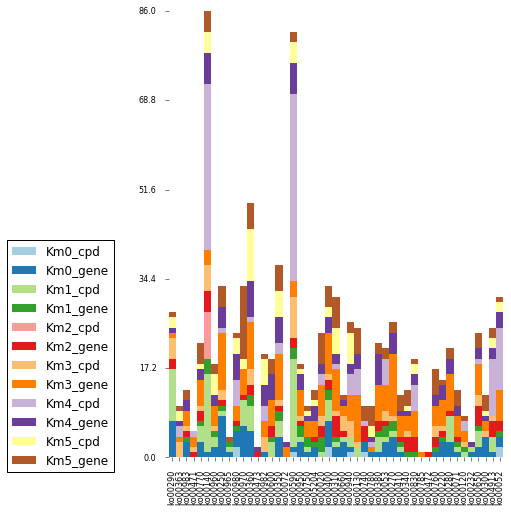

In [128]:
# d_widths = [.5,1.,3.,2.,1.,2.,5.,4.]
# d_labels = ["fred","julie","sam","peter","rob","baz"]
# d_labels = oneList

# d_colors = ['#7fc97f', '#beaed4', '#fdc086', '#ffff99', '#386cb0','#f0027f']
d_colors = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f','#ff7f00','#cab2d6',
            '#6a3d9a','#ffff99','#b15928']

fig = plt.figure(figsize=(6,8)) #setting this here keeps the x-axis labels in the actual figure
# fig.subplots_adjust(bottom=0.1)
ax = fig.add_subplot(111)
SBG.stackedBarPlot(ax,
                   dataToPlot,
                   d_colors,
                   xLabels=dataToPlot.index,
                   )

    
# ax.legend(fL,loc='upper left',bbox_to_anchor=(1,0.5))
leg = ax.legend(list(dataToPlot.columns.values),loc='upper left',bbox_to_anchor=([-0.5, 0.5]))
# Customize legend title
# Set position to increase space between legend and labels
plt.setp(leg.get_title(), fontsize=20, alpha=a)
leg.get_title().set_position((0, 10))


# ax.legend(fL,loc = 'best')

# plt.title("6 Kmeans groups")

#fig.savefig('stackedBar'+'.png',bbox_inches = 'tight') #adding bbox_inches finally gets everything exported
plt.savefig('exportFigABC.eps', format='eps', dpi=1000,bbox_inches = 'tight')



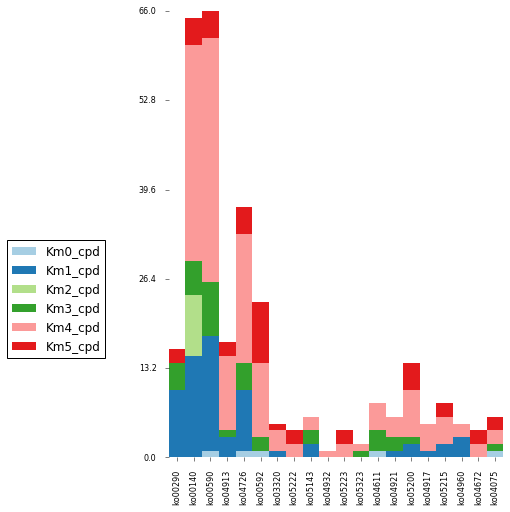

In [129]:
newCols = colLabel[4::2]
#Python oddball: start at 4, go every two.

s = gatherCounts[(gatherCounts.loc[:,'percentCpds'].values > 40)]
dataToPlot = s.loc[:,newCols]

# d_widths = [.5,1.,3.,2.,1.,2.,5.,4.]
#d_labels = ["fred","julie","sam","peter","rob","baz"]
#d_labels = oneList

# d_colors = ['#7fc97f', '#beaed4', '#fdc086', '#ffff99', '#386cb0','#f0027f']
d_colors = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f','#ff7f00','#cab2d6',
            '#6a3d9a','#ffff99','#b15928']

fig = plt.figure(figsize=(6,8)) #setting this here keeps the x-axis labels in the actual figure
# fig.subplots_adjust(bottom=0.1)
ax = fig.add_subplot(111)
SBG.stackedBarPlot(ax,
                   dataToPlot,
                   d_colors,
                   xLabels=dataToPlot.index,
                   )

    
# ax.legend(fL,loc='upper left',bbox_to_anchor=(1,0.5))
leg = ax.legend(list(dataToPlot.columns.values),loc='upper left',bbox_to_anchor=([-0.5, 0.5]))
# Customize legend title
# Set position to increase space between legend and labels
plt.setp(leg.get_title(), fontsize=20, alpha=a)
leg.get_title().set_position((0, 10))


# ax.legend(fL,loc = 'best')

# plt.title("6 Kmeans groups")

#fig.savefig('stackedBar'+'.png',bbox_inches = 'tight') #adding bbox_inches finally gets everything exported
# plt.savefig('exportFigABC.eps', format='eps', dpi=1000,bbox_inches = 'tight')

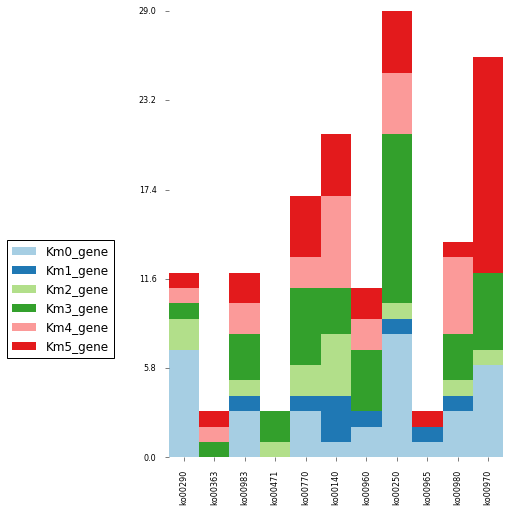

In [130]:
newCols = colLabel[5::2]
#start at 5, this yields only the genes

s = gatherCounts[(gatherCounts.loc[:,'percentGenes'].values > 40)]
dataToPlot = s.loc[:,newCols]

# d_widths = [.5,1.,3.,2.,1.,2.,5.,4.]
# d_labels = ["fred","julie","sam","peter","rob","baz"]
# d_labels = oneList

# d_colors = ['#7fc97f', '#beaed4', '#fdc086', '#ffff99', '#386cb0','#f0027f']
d_colors = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f','#ff7f00','#cab2d6',
            '#6a3d9a','#ffff99','#b15928']

fig = plt.figure(figsize=(6,8)) #setting this here keeps the x-axis labels in the actual figure
# fig.subplots_adjust(bottom=0.1)
ax = fig.add_subplot(111)
SBG.stackedBarPlot(ax,
                   dataToPlot,
                   d_colors,
                   xLabels=dataToPlot.index,
                   )

    
# ax.legend(fL,loc='upper left',bbox_to_anchor=(1,0.5))
leg = ax.legend(list(dataToPlot.columns.values),loc='upper left',bbox_to_anchor=([-0.5, 0.5]))
# Customize legend title
# Set position to increase space between legend and labels
plt.setp(leg.get_title(), fontsize=20, alpha=a)
leg.get_title().set_position((0, 10))


# ax.legend(fL,loc = 'best')

# plt.title("6 Kmeans groups")

#fig.savefig('stackedBar'+'.png',bbox_inches = 'tight') #adding bbox_inches finally gets everything exported
# plt.savefig('exportFigABC.eps', format='eps', dpi=1000,bbox_inches = 'tight')

In [131]:
pathstr = kegg_list('ko00290').read()

In [132]:
pathstr

'path:ko00290\tValine, leucine and isoleucine biosynthesis\n'

In [133]:
pathstr.split('\t')[1].rstrip() #yikes!

'Valine, leucine and isoleucine biosynthesis'

In [134]:
#want to export gatherCounts, with the added pathway name as a new column
gatherCounts['pathwayInfo'] = ''

In [135]:
#put the pathway name into the data frame before exporting it
for item in gatherCounts.index:
    pathstr = kegg_list(item).read()
    #this next line splits the string at the '\t', then keeps the piece at index = 1, and strips off the '\n'!!
    gatherCounts.loc[item,('pathwayInfo')] = pathstr.split('\t')[1].rstrip()

In [136]:
gatherCounts.head(5)

,nCpds,nGenes,nCpdsFound,nGenesFound,Km0_cpd,Km0_gene,Km1_cpd,Km1_gene,Km2_cpd,Km2_gene,...,Km3_gene,Km4_cpd,Km4_gene,Km5_cpd,Km5_gene,sumCpds,percentCpds,sumGenes,percentGenes,pathwayInfo
ko00290,23,17,0,0,0,7,10,0,0,2,...,1,0,1,2,1,16,69.565217,12,70.588235,"Valine, leucine and isoleucine biosynthesis"
ko00363,25,5,0,0,0,0,0,0,0,0,...,1,2,1,2,1,7,28.000000,3,60.000000,Bisphenol degradation
ko00983,49,22,0,0,0,3,0,1,0,1,...,3,0,2,0,2,1,2.040816,12,54.545455,Drug metabolism - other enzymes
ko00471,12,6,0,0,0,0,0,0,0,1,...,2,1,0,0,0,2,16.666667,3,50.000000,D-Glutamine and D-glutamate metabolism
ko00770,28,36,0,0,0,3,3,1,0,2,...,5,0,2,1,4,5,17.857143,17,47.222222,Pantothenate and CoA biosynthesis


In [137]:
#now export the result as CSV file
gatherCounts.to_csv('pathways_with_Kmeans_KOnorm2Max.csv', header = True)